# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [3]:
df.email.nunique()

5148

In [4]:
df.shape

(45993, 3)

In [5]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [6]:
df_content.doc_status.nunique()

1

In [7]:
df.groupby(['article_id', 'title']).email.count().sort_values(ascending = False).head()

article_id  title                                                       
1429.0      use deep learning for image classification                      937
1330.0      insights from new york car accident reports                     927
1431.0      visualize car data with brunel                                  671
1427.0      use xgboost, scikit-learn & ibm watson machine learning apis    643
1364.0      predicting churn with the spss random tree algorithm            627
Name: email, dtype: int64

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [8]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [9]:
df.groupby('email', as_index = False).article_id.count().sort_values(by = 'article_id', ascending = False).head()

,email,article_id
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


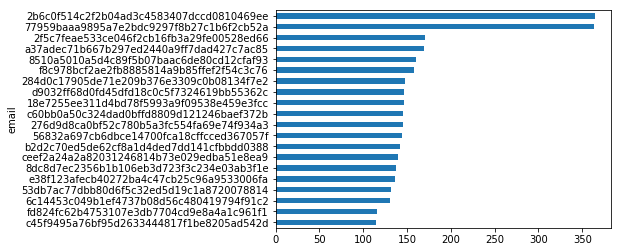

In [10]:
df.groupby('email').article_id.count().sort_values(ascending = False)[:20][::-1].plot(kind = 'barh');

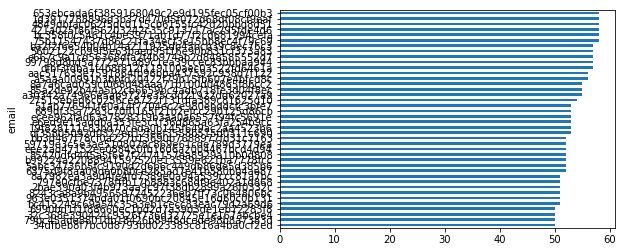

In [11]:
df.groupby('email').article_id.count().sort_values(ascending = False)[100:140][::-1].plot(kind = 'barh');

In [12]:
np.percentile(df.groupby('email').article_id.count(), [50, 100])

array([   3.,  364.])

In [13]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [14]:
# Find and explore duplicate articles
df_content[df_content.article_id.duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [15]:
df_content.shape

(1056, 5)

In [16]:
# Remove any rows that have the same article_id - only keep the first
index_to_drop = df_content[df_content.article_id.duplicated()].index
df_content.drop(index_to_drop, inplace = True)

In [17]:
df_content.shape

(1051, 5)

In [18]:
df_content.article_id.nunique()

1051

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [19]:
print(df.article_id.nunique())
print(df_content.article_id.nunique())
print(df.email.nunique())
print(df.shape[0]) 

714
1051
5148
45993


In [20]:
df['article_id'] = df['article_id'].astype('int')

In [21]:
content_articles = df_content.article_id.unique().tolist()
df_articles = df.article_id.unique().tolist()
articles_in_only_content = [i for i in content_articles if not i in df_articles]

In [22]:
len(articles_in_only_content)

614

In [23]:
total_articles = df.article_id.nunique() + len(articles_in_only_content)
total_articles

1328

There are 714 unique articles in df and 614 unique articles that are present in df_content but not present in df. So it gives a total of 714 + 614 = 1328 unique articles in the database.

In [24]:
unique_articles = 714# The number of unique articles that have at least one interaction
total_articles = 1051# The number of unique articles on the IBM platform
unique_users = 5148# The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [25]:
df.groupby('article_id').email.count().sort_values(ascending = False).head()

article_id
1429    937
1330    927
1431    671
1427    643
1364    627
Name: email, dtype: int64

In [26]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [27]:
df[df.email.isnull()]

,article_id,title,email
25131,1016,why you should master r (even if it might even...,NaN
29758,1393,the nurse assignment problem,NaN
29759,20,working interactively with rstudio and noteboo...,NaN
29760,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,62,data visualization: the importance of excludin...,NaN
35264,224,"using apply, sapply, lapply in r",NaN
35276,961,beyond parallelize and collect,NaN
35277,268,sector correlations shiny app,NaN
35278,268,sector correlations shiny app,NaN
35279,268,sector correlations shiny app,NaN


In [28]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [29]:
# bence the number of unique articles in IBM platform kismi yanlis dhaa fazla olmali.------- bunu sor

In [30]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [31]:
df[df[['article_id', 'user_id']].duplicated()].head()

,article_id,title,user_id
41,1429,use deep learning for image classification,3
75,1429,use deep learning for image classification,7
95,1162,analyze energy consumption in buildings,40
97,409,using github for project control in dsx,23
99,1393,the nurse assignment problem,21


In [32]:
temp = df.groupby(['article_id', 'title']).user_id.count().sort_values(ascending = False)
temp = temp.reset_index()
temp.head(10)

,article_id,title,user_id
0,1429,use deep learning for image classification,937
1,1330,insights from new york car accident reports,927
2,1431,visualize car data with brunel,671
3,1427,"use xgboost, scikit-learn & ibm watson machine...",643
4,1364,predicting churn with the spss random tree alg...,627
5,1314,healthcare python streaming application demo,614
6,1293,finding optimal locations of new store using d...,572
7,1170,"apache spark lab, part 1: basic concepts",565
8,1162,analyze energy consumption in buildings,512
9,1304,gosales transactions for logistic regression m...,483


In [33]:
def get_top_articles(n, df = df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    temp = df.groupby(['article_id', 'title']).user_id.count().sort_values(ascending = False)
    temp = temp.reset_index()
    article_titles = temp['title'][:n].tolist()
    
    return article_titles


def get_top_article_ids(n, df = df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    temp = df.groupby('article_id').user_id.count().sort_values(ascending = False)
    temp = temp.reset_index()
    articles = temp['article_id'][:n].tolist()

    return articles

In [34]:
print(get_top_articles(5))
print(get_top_article_ids(5))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm']
[1429, 1330, 1431, 1427, 1364]


In [35]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [69]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [70]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
df['article_id'] = df['article_id'].astype('int')

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [72]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In user-item matrix, if the user did not read the article or he has not read it yet, we code it as zero. So all values in the matrix are either zero or one, there is no null values. In user rating matrix, if the user has not seen the movie or if the user saw it and did not want to rate it, then there is no rating value in the matrix. In other words, some values in the matrix are null values and it makes SVD impossible to work. That is why we can apply SVD here. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

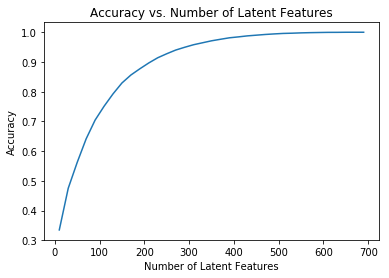

In [73]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [74]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    test_idx = df_test.user_id.unique().tolist()
    test_arts = df_test.article_id.unique().tolist()
    
    train = df_train.drop_duplicates()
    user_item_train = train.groupby(['user_id', 'article_id']).title.count().unstack().fillna(0)
    
    test = df_test.drop_duplicates()
    user_item_test = test.groupby(['user_id', 'article_id']).title.count().unstack().fillna(0)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [75]:
print('There are total of {} users in the test set'.format(len(test_idx)))
print('There are total of {} articles in the test set.'.format(len(test_arts)))


#new users in test user-item matrix
new_users = [i for i in test_idx if not i in df_train.user_id.unique().tolist()]
print('The number of new users is {} in the test set.'.format(len(new_users)))

#new articles in test user-item matrix
new_articles = [i for i in test_arts if not i in df_train.article_id.unique().tolist()]
print('The number of new articles is {} in the test set.'.format(len(new_articles)))

There are total of 682 users in the test set
There are total of 574 articles in the test set.
The number of new users is 662 in the test set.
The number of new articles is 0 in the test set.


In [76]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many movies can we make predictions for in the test set?': b,# letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [77]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

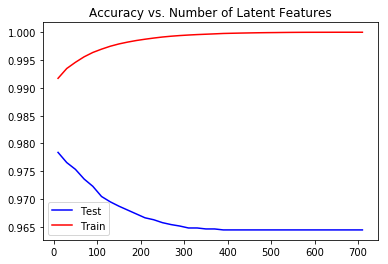

In [78]:

row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)

# user-item test matrix consists of corresponding rows and columns of user_item_train
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

# get subset of rows and columns that are common in train and test datasets
common_index = user_item_train.index.intersection(user_item_test.index)
common_cols = user_item_train.columns.intersection(user_item_test.columns)

# subset of test and dataset
test_20 = user_item_test.loc[common_index, common_cols]

k_range = np.arange(10, 700 + 20, 20)
all_errs = []
train_err_lst = []
test_err_lst = []

for k in k_range:
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(test_20, user_item_test_preds)
    
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    train_err_lst.append(err_train)
    test_err_lst.append(err_test)
    
    

plt.plot(k_range, 1 - np.array(test_err_lst)/(test_20.shape[0]*test_20.shape[1]), 'b', label = 'Test')
plt.plot(k_range, 1 - np.array(train_err_lst)/(user_item_train.shape[0]*user_item_train.shape[1]), 'r', label = 'Train');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();
    

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

As the number of latent features increase, the accuracy of train data increases and the accuracy of test data decreases. When we take around 200 latent features, the accuracies of test data and all train data are relatively good. But it is kind of naive predictor. In this problem, in user-item matrices there is no null values. As we increase the number of latent features, what we get as user-item-test-predictons at the end is actually subset of exact user-item train matrix. If there is no user revisiting the articles she read, then it means there is no common 1 between user-item-test and user-item-train matrices. We do not suggest any article to any reader. Accuracy is high due to the high number of common zeros between those two matrices. It is like the situation where we say all emails are real, there is no spam and we get 99% accuracy. 

To see how our recommendation system is effective, I would suggest doing A/B test. It is basically comparison of some metrics between control and experiment groups. Here, there are important point to keep an eye on. First, we need to make sure that assigning users to control and experiment groups should be completely or as high as possible random to control for variables other than the metrics we want to see a difference. We can use cookie-based divertion. In this case, the number of users in both groups should be same.  So half of the users see recommendations of new recommendation system and other half do not see. With the help of this randomization, variables like age, gender, education do not introduce bias into the results. 
As an variant metric, one option might be the average number of articles read by users. If recommendations are good, user continues reading and it increases the number of articles read by users. If recommendation system is not effective, recommendations would not be in line with interests of the user and we will see no increase in the average number of articles at the end. The duration depends on the size of the experiment and this in turn depends on statistical power we want. If we want higher power, it needs larger size thus more days of experiment. In this case, null hypothesis will be that the average articles read by users are the same in two groups, alternative hypothesis will be the number in experiment group is larger than the number on control group (one-tailed). So we cannot reject the null hypothesis until we see a substantial (higher p-value) increase in the average number of articles read by users.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 